In [2]:
%matplotlib inline
import math
import pandas as pd
import networkx as nx
from graph_tool.all import Graph, motifs, closeness, betweenness, global_clustering, graph_draw
from graph_tool.clustering import *
import numpy as np
import matplotlib.pyplot as plt
DATA_FILE = "data/soc-sign-bitcoinotc.csv"

In [3]:
df = pd.read_csv(DATA_FILE)
print(df.head())

   source  target  weight     timestamp
0       6       2       4  1.289242e+09
1       6       5       2  1.289242e+09
2       1      15       1  1.289243e+09
3       4       3       7  1.289245e+09
4      13      16       8  1.289254e+09


In [4]:
g = Graph(directed=True)
g.vp['name'] = g.new_vp('string')
g.ep['weight'] = g.new_ep('int')
g.ep['timestamp'] = g.new_ep('float')
nodes = set()

for i,row in df.iterrows():
    nodes.add(int(row[0]))
    nodes.add(int(row[1]))
for node in nodes:
    v = g.add_vertex()
    g.vp['name'][v] = node
nodes = list(nodes)
for i,row in df.iterrows():
    s = nodes.index(row[0])
    t = nodes.index(row[1])
    vs = g.vertex(s)
    vt = g.vertex(t)
    e = g.add_edge(vs, vt)
    g.ep['weight'][e] = row[2]
    g.ep['timestamp'][e] = 0
    if(len(row)==4):
        g.ep['timestamp'][e] = row[3]
del df
print("Vertex count:",g.num_vertices())
print("Edge count:",g.num_edges())

Vertex count: 5881
Edge count: 35592


We started our project with one question in mind, that is: can motifs bring some information about the presence of fraudulent users in a crypto trust network? Although it's an important question, we understood that in order to answer this first question we may need to answer another one: are the motifs in this network *relevant*? 
The answer is yes and we arranged a montecarlo simulation to verify that, our work can be found in the second notebook, here below there's a chart summing up our work.

In [5]:
from IPython.display import Image
#Image(filename='motif.jpg')

So after asserting that the motifs observed in the two networks are *relevant* we proceeded in verifying if they can also help in answering the first question. Let's first make clear our aim: what we want to do is finding whether there's a correlation between some motifs and the presence of *fraudulent* users in both bitcoin-otc and bitcoin-alpha networks. 
We proceeded this way:
    - Using a known to be working algorithm we derived some metrics (goodness and fairness) for every node and used it to classify every player as *good* or *evil*. 
    - Then we runned the motifs algorithm (form the graph-tools library) that implements the ESU algorithm to find the most relevant graphlets in the considered network. 
    - Finally we counted the numer of times one or more *evil* nodes appeared in those motifs 

In [6]:
def compute_fairness_goodness(G, it):
    fairness = {}
    goodness = {}
    for i in G.nodes():
        fairness[i] = 1
        goodness[i] = 1
    nodes = G.nodes()
    iter = 0
    while iter < it:
        df = 0
        dg = 0
        for node in nodes:
            inedges = G.in_edges(node, data='weight')
            g = 0
            for edge in inedges:
                g += fairness[edge[0]]*edge[2]
            try:
                dg += abs(g/len(inedges) - goodness[node])
                goodness[node] = g/len(inedges)
            except:
                pass
        for node in nodes:
            outedges = G.out_edges(node, data='weight')
            f = 0
            for edge in outedges:
                f += 1.0 - abs(edge[2] - goodness[edge[1]])/2.0
            try:
                df += abs(f/len(outedges) - fairness[node])
                fairness[node] = f/len(outedges)
            except:
                pass
        #exit condition / convergence
        if df < math.pow(10, -6) and dg < math.pow(10, -6):
            break
        iter+=1
    return fairness, goodness

fairness - goodness and trust computation on our network

In [7]:
G = nx.MultiDiGraph()
file = open(DATA_FILE,"r")
for l in file:
    if "source" in l:
        pass
    else:
        ls = l.strip().split(",")
        G.add_edge(int(ls[0]), int(ls[1]), weight = float(ls[2])/10) ## the weight should already be in the range of -1 to 1
file.close()
fairness, goodness = compute_fairness_goodness(G,10000)
trust = [(1-fairness[i])*goodness[i] for i in fairness.keys()]

nodes - trust plot

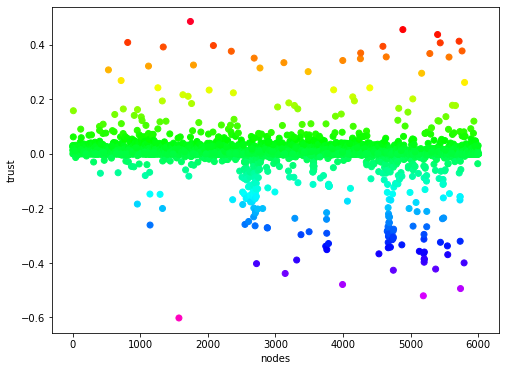

In [8]:
plt.figure(figsize=(8,6))
plt.scatter(fairness.keys(),trust,cmap='gist_rainbow_r',c=trust)
plt.xlabel("nodes")
plt.ylabel("trust")
plt.show()

In [9]:
TRESHOLD = -0.1 # Tunable parameter, can be set considering the graph above
badguys = set()
for i in goodness.keys():
    if goodness[i]*(1-fairness[i]) < TRESHOLD:
        badguys.add(int(i))
print(len(badguys))
#graph_draw(g, output_size=(3000, 1500),vertex_fill_color = g.vp['good'], edge_color = g.ep['weight'], output="prova1.png")

141


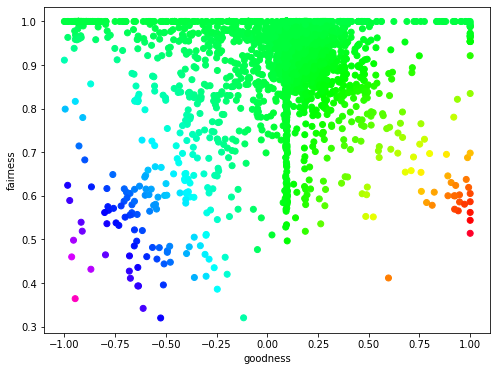

In [10]:
plt.figure(figsize=(8,6))
plt.scatter(goodness.values(),fairness.values(),cmap='gist_rainbow_r',c=trust)
plt.xlabel("goodness")
plt.ylabel("fairness")
plt.show()

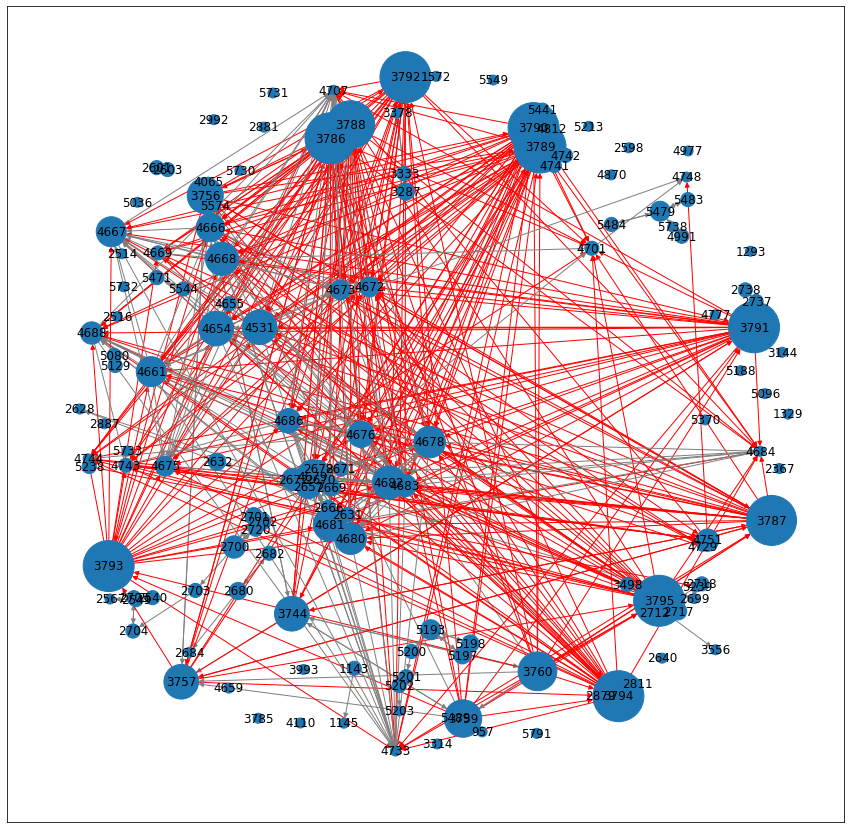

In [11]:
G1 = nx.MultiDiGraph()

for i,j,dt in G.edges(data = True):
    if i in badguys:
        G1.add_node(i)
        if j in badguys:
            G1.add_node(j)
            G1.add_edge(i,j,weight = dt['weight'])

plt.figure(figsize=(15, 15))
nx.draw_networkx(G1,with_labels = True, pos=nx.spring_layout(G1), width=1.0, 
    edge_color=["red"if e[2]<0 else "gray" for e in G1.edges(data='weight')],
    node_size= [100+len(n[1])*100 for n in G1.adjacency()])
plt.rcParams['axes.facecolor']='white'
#plt.savefig("drawings/bg_chart_"+DATA_FILE[5:-4]+".png")

ESU algorithm execution

In [12]:
motif_res = motifs(g,k=3, return_maps=True)#ESU implemented motif count

Motifs and occurrences from the original graph

Motif no. 1, occurrencies: 153801


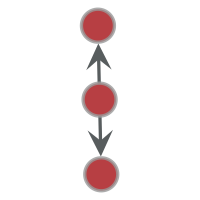

Motif no. 2, occurrencies: 36648


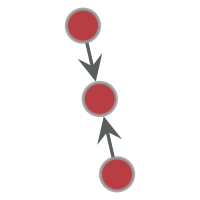

Motif no. 3, occurrencies: 65143


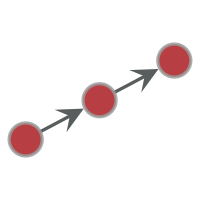

Motif no. 4, occurrencies: 3706


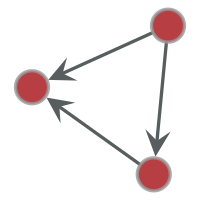

Motif no. 5, occurrencies: 440712


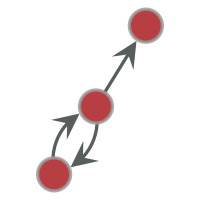

Motif no. 6, occurrencies: 169731


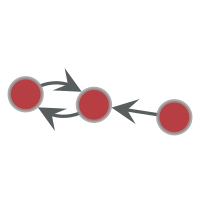

Motif no. 7, occurrencies: 79


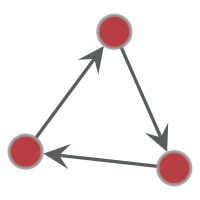

Motif no. 8, occurrencies: 2910


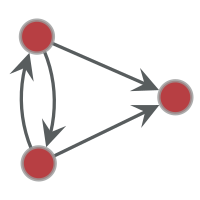

Motif no. 9, occurrencies: 2048


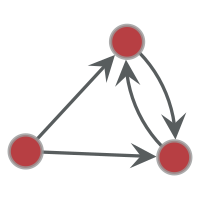

Motif no. 10, occurrencies: 729665


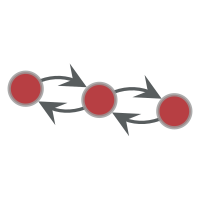

Motif no. 11, occurrencies: 1621


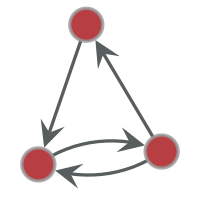

Motif no. 12, occurrencies: 9377


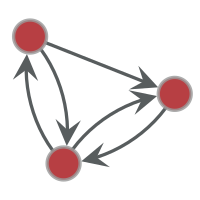

Motif no. 13, occurrencies: 13752


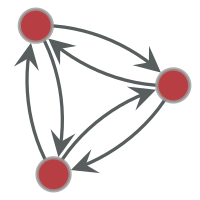

In [13]:
for ind,item in enumerate(motif_res[0]):
    print("Motif no. %d, occurrencies: %d"%(ind+1,motif_res[1][ind]))
    graph_draw(item,bg_color='white', output_size=(100,100), adjust_aspect = False)#, output="drawings/motif_g/motif_"+str(ind)+".png")

Count the bad occurrencies algorithm

In [14]:
bad = [0]*len(motif_res[1])
bad_2 = [0]*len(motif_res[1])
total = motif_res[1]
motifs_vertex_maps = motif_res[2]
for index,motif_vertex_maps in enumerate(motifs_vertex_maps):
    for map in motif_vertex_maps:
        count = 0
        for vertex in map:
            if int(g.vp['name'][vertex]) in badguys:
                count+=1
        if count >= 1:
            bad[index] += 1
        if(count>1):
            bad_2[index]+=1


Total occurrences vs at least one evil vs at least two evil

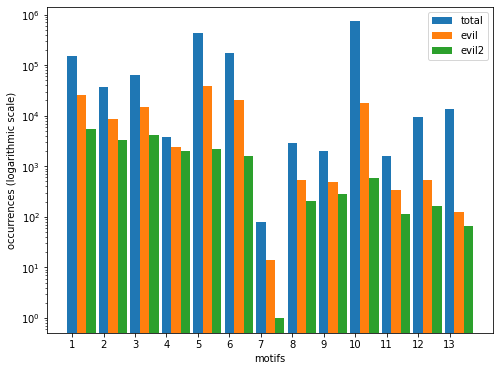

In [15]:
#print(motif_res[1])
plt.figure(figsize=(8,6))
plt.bar(np.arange(1,len(total)+1),total, width=.3)
plt.bar(np.arange(1,len(bad)+1) +.3,bad, width=.3)
plt.bar(np.arange(1,len(bad_2)+1) +.6,bad_2, width=.3)
plt.legend(['total','evil','evil2'])
plt.yscale('log')
plt.xticks(range(1,len(bad)+1))
plt.xlabel("motifs")
plt.ylabel("occurrences (logarithmic scale)")
plt.show()

evil1 ratio vs evil2 ratio

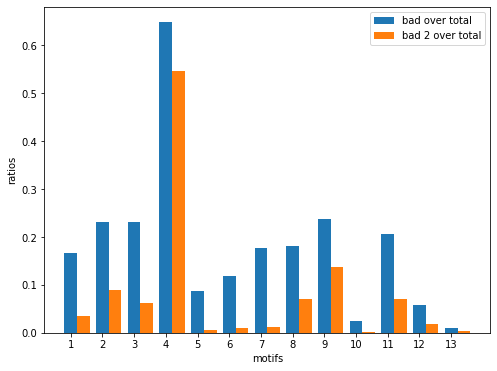

In [16]:
rateo = [item/total[i] for i,item in enumerate(bad)]
rateo_2 = [item/total[i] for i,item in enumerate(bad_2)]
plt.figure(figsize=(8,6))
plt.bar(np.arange(1,len(rateo)+1),rateo, width=.4)
plt.bar(np.arange(1,len(rateo_2)+1)+.4,rateo_2, width=.4)
plt.legend(['bad over total','bad 2 over total'])
plt.xticks(range(1,len(rateo)+1))
plt.xlabel("motifs")
plt.ylabel("ratios")
plt.show()